<h1>Прогнозирование большого количества рядов</h1>

In [1]:
#Импорт модулей 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pickle

from scipy.stats import binned_statistic_dd
import scipy.stats as scs

from sklearn import manifold
from sklearn import preprocessing
from sklearn import random_projection
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa as tsa
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.statespace import sarimax

from itertools import product as prdct
from tqdm import tqdm

from IPython.display import clear_output
%pylab inline

Populating the interactive namespace from numpy and matplotlib


<h3>Загрузка и обработка данных</h3>

Считываем и предобрабатываем данные аналогично предыдущим неделям

In [2]:
#Парсер ячеек со временем
def filter_datetime(x):
    try:
        return datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S')
    except:
        return np.nan

# Год и месяц начала и конца считывания данных (март-июнь)
START = datetime.datetime.strptime('2016-3','%Y-%m')
END = datetime.datetime.strptime('2016-7','%Y-%m')

# 1 мая разделяет обучающую и тестовую выборки
TT_SPLIT = datetime.datetime.strptime('2016-5','%Y-%m')

# Функция для преобразования даты в кол-во часов от начала считывания
def date_to_hour(date):
    return int((date-START).total_seconds()/3600)

In [51]:
#большая таблица, в которую будут записанны все данные
raw = pd.DataFrame()
for current in range(START.month-1, (END.year-START.year)*12+END.month-1):
    
    #считываем файлы в цикле
    clear_output()
    print('Считывание yellow_tripdata_{0}-{1:0>2}.csv'.format(START.year+current//12,current%12+1))
    tmp = pd.read_csv('yellow_tripdata_{0}-{1:0>2}.csv'.format(START.year+current//12,current%12+1))
          
    #clear_output()      
    print('Обработка yellow_tripdata_{0}-{1:0>2}.csv'.format(START.year+current//12,current%12+1))
          
    #сразу удаляем ненужные столбцы
    print('Удаление лишних столбцов')
    tmp = tmp[['tpep_dropoff_datetime','tpep_pickup_datetime',
               'passenger_count','trip_distance','pickup_longitude',
               'pickup_latitude']]
    
    #парсим ячейки со временем 
    print('Парсинг ячеек со временем')
    tmp['tpep_dropoff_datetime'] = tmp['tpep_dropoff_datetime'].map(filter_datetime)
    tmp['tpep_pickup_datetime'] = tmp['tpep_pickup_datetime'].map(filter_datetime)
    tmp.dropna()
   
        
    #считаем длительность поездки
    print('Вычисление длительностей поездок')
    tmp['duration'] = tmp['tpep_dropoff_datetime']-tmp['tpep_pickup_datetime']
    
    #удаляем поездки с нулевой длительностью
    print('удаление поездок с нулевой длительностью')
    tmp = tmp.loc[tmp['duration'] != datetime.timedelta(0)]
    
    #удаляем поездки с нулевым количеством пассажиров
    print('удаление поездок с нулевым кол-вом пассажиров')
    tmp = tmp.loc[tmp['passenger_count'] > 0]

    #удаляем поездки с нулевой дистанцией
    print('удаление поездок с нулевой дистанцией')
    tmp['trip_distance'] = tmp['trip_distance'].map(lambda x: x if (isinstance(x,int) or isinstance(x,float)) else np.nan)
    tmp.dropna()                                               
    tmp = tmp.loc[(tmp['trip_distance'] > 0)]#& (tmp['trip_distance'] < 100)]

    #добавим в данные столбец, содержащий количество часов от начала отсчета 
    print('вычисление кол-ва часов от начала')
    tmp['pickup_hour'] = tmp['tpep_pickup_datetime'].map(date_to_hour)
    
    tmp = tmp[['pickup_hour','pickup_longitude','pickup_latitude']]
    
    #добавляем данные в общую таблицу
    print('Добавление в общую таблицу')
    raw = raw.append(tmp)
               
#clear_output()     
print('Размер прочитанных данных:', raw.shape)


Считывание yellow_tripdata_2016-06.csv
Обработка yellow_tripdata_2016-06.csv
Удаление лишних столбцов
Парсинг ячеек со временем
Вычисление длительностей поездок
удаление поездок с нулевой длительностью
удаление поездок с нулевым кол-вом пассажиров
удаление поездок с нулевой дистанцией
вычисление кол-ва часов от начала
Добавление в общую таблицу
Размер прочитанных данных: (46823033, 3)


In [52]:
raw.describe()

,pickup_hour,pickup_longitude,pickup_latitude
count,4.682303e+07,4.682303e+07,4.682303e+07
mean,1.439195e+03,-7.304034e+01,4.023689e+01
std,8.409248e+02,8.255756e+00,4.547994e+00
min,0.000000e+00,-1.650819e+02,-4.456935e+01
25%,7.180000e+02,-7.399179e+01,4.073635e+01
50%,1.433000e+03,-7.398150e+01,4.075354e+01
75%,2.157000e+03,-7.396644e+01,4.076825e+01
max,2.927000e+03,1.184089e+02,6.685682e+01


In [53]:
#считываем координаты ячеек
bins = pd.read_csv('regions.csv',sep=';')
#создаем сетку для агрегации
x_bins = list(bins.west[list(range(0,2499,50))])
y_bins = list(bins.south[list(range(0,50))])
x_bins.append(bins.east[2499])
y_bins.append(bins.north[49])
t_bins = list(range(0,date_to_hour(END)))
t_bins.append(t_bins[-1]+1)
print(len(x_bins),len(y_bins),len(t_bins))


51 51 2929


In [54]:
#агрегируем данные по регионам и часам

stat = binned_statistic_dd([raw['pickup_longitude'].values,
                            raw['pickup_latitude'].values,
                            raw['pickup_hour'].values],
                            None,'count',bins=[x_bins,y_bins,t_bins])

maxnum = max(stat.statistic.ravel())
print('Наибольшее кол-во: {0}\nКоличество регионов: {1}'.format(maxnum,stat.statistic.shape))

Наибольшее кол-во: 2485.0
Количество регионов: (50, 50, 2928)


In [55]:
#сохраняем результат в датафрейм в удобном для дальнейшей работы формате
data = pd.DataFrame(stat.statistic.reshape(stat.statistic.shape[0]*stat.statistic.shape[1],
                                           stat.statistic.shape[2]).T)
data.columns = data.columns.map(lambda x: x+1)


In [56]:
#фильтруем регионы как в задании второй недели
reg = pd.read_csv('regnum.csv')
data = data[reg['0']]
data

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
0,14.0,22.0,20.0,39.0,78.0,124.0,183.0,193.0,212.0,31.0,...,4.0,0.0,1.0,105.0,16.0,59.0,20.0,146.0,12.0,120.0
1,16.0,15.0,12.0,12.0,58.0,60.0,98.0,122.0,144.0,14.0,...,5.0,0.0,2.0,5.0,1.0,33.0,9.0,71.0,6.0,23.0
2,4.0,14.0,0.0,9.0,23.0,55.0,59.0,93.0,162.0,21.0,...,10.0,1.0,0.0,0.0,0.0,1.0,0.0,18.0,0.0,0.0
3,2.0,7.0,1.0,4.0,16.0,35.0,39.0,63.0,119.0,11.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,1.0
4,5.0,16.0,2.0,8.0,30.0,31.0,25.0,44.0,79.0,4.0,...,7.0,0.0,0.0,4.0,1.0,0.0,0.0,34.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2923,116.0,190.0,135.0,132.0,395.0,308.0,401.0,336.0,496.0,260.0,...,2.0,44.0,4.0,297.0,311.0,104.0,9.0,142.0,96.0,1.0
2924,104.0,142.0,149.0,141.0,333.0,368.0,390.0,385.0,560.0,247.0,...,1.0,27.0,7.0,288.0,344.0,103.0,24.0,209.0,145.0,0.0
2925,151.0,162.0,145.0,135.0,359.0,422.0,460.0,541.0,672.0,259.0,...,2.0,21.0,9.0,287.0,307.0,185.0,9.0,213.0,142.0,1.0
2926,106.0,168.0,103.0,125.0,317.0,476.0,405.0,508.0,578.0,259.0,...,3.0,19.0,5.0,358.0,387.0,169.0,12.0,206.0,146.0,0.0


In [57]:
#сохраним данные в файл
data.to_csv('data_march-june.csv', index=False)

<h3>Кластеризация данных</h3>

Отшкалируем данные по регионам

In [10]:
data = pd.read_csv('data_march-june.csv')

In [11]:
data.describe()

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
count,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,...,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000
mean,67.487022,138.530396,87.807036,68.156762,188.225410,272.054645,298.292691,342.674522,412.609631,139.684768,...,4.910519,12.650273,5.355191,210.182719,179.310792,91.797131,10.485997,140.951844,39.552254,57.372609
std,42.089333,82.277828,58.449479,39.434416,98.306169,136.819352,167.279114,193.132938,241.406350,75.622247,...,4.519425,13.236539,3.955276,146.263725,135.052062,59.206672,8.744981,76.755933,37.543051,42.250876
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,3.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.750000,55.000000,27.000000,35.000000,108.000000,169.750000,186.250000,218.000000,256.000000,89.000000,...,2.000000,0.000000,2.000000,41.750000,19.000000,44.000000,4.000000,79.000000,6.000000,17.750000
50%,73.000000,163.000000,96.000000,71.000000,199.500000,287.000000,292.000000,308.000000,358.000000,144.000000,...,4.000000,10.000000,5.000000,247.000000,202.000000,92.000000,9.000000,148.000000,34.000000,58.000000
75%,100.000000,204.000000,128.000000,94.000000,255.250000,359.250000,390.000000,443.250000,548.250000,188.000000,...,7.000000,22.000000,8.000000,328.000000,291.000000,139.000000,15.000000,202.000000,61.000000,88.000000
max,205.000000,369.000000,272.000000,247.000000,496.000000,681.000000,810.000000,1109.000000,1419.000000,476.000000,...,41.000000,67.000000,19.000000,708.000000,564.000000,273.000000,57.000000,357.000000,249.000000,194.000000


In [12]:
#используем только данные до мая
scaled = pd.DataFrame(preprocessing.scale(data))
scaled = scaled.iloc[:date_to_hour(TT_SPLIT)]
scaled.describe()

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,101
count,1464.000000,1464.000000,1464.000000,1464.000000,1464.000000,1464.000000,1464.000000,1464.000000,1464.000000,1464.000000,...,1464.000000,1464.000000,1464.000000,1464.000000,1464.000000,1464.000000,1464.000000,1464.000000,1464.000000,1464.000000
mean,-0.044832,-0.002520,-0.004284,0.033687,0.040453,0.070106,0.057044,0.058442,-0.006788,-0.055130,...,-0.004988,-0.029987,-0.041109,-0.005766,-0.052271,-0.047402,-0.049647,-0.050088,-0.248964,0.181171
std,0.957662,1.008859,1.005871,1.053515,1.020097,1.038075,1.047038,1.063701,1.009336,0.962799,...,1.009525,0.985574,0.981917,1.033037,0.954476,0.980813,0.959825,0.994582,0.699553,0.900752
min,-1.603697,-1.683978,-1.502529,-1.728653,-1.915013,-1.981452,-1.777529,-1.759061,-1.705340,-1.847454,...,-1.086722,-0.955872,-1.354167,-1.437257,-1.327943,-1.550717,-1.199292,-1.836678,-1.053697,-1.358135
25%,-0.985858,-1.054904,-1.061902,-0.866314,-0.816216,-0.696692,-0.619087,-0.650826,-0.666458,-0.696802,...,-0.644112,-0.955872,-0.848427,-1.179118,-1.187232,-0.875002,-0.741809,-0.833327,-0.920494,-0.417166
50%,0.107242,0.309609,0.174419,0.097476,0.180839,0.189665,-0.013708,-0.127781,-0.246969,0.037234,...,-0.201502,-0.275820,-0.089817,0.183380,0.116191,-0.038805,-0.227140,0.039719,-0.387681,0.180557
75%,0.725081,0.808006,0.687771,0.706185,0.742955,0.737926,0.669399,0.586875,0.561972,0.562963,...,0.462412,0.630917,0.668793,0.798812,0.723468,0.746713,0.430492,0.730337,0.278335,0.796034
max,2.436021,2.181636,3.083411,4.535982,2.398780,2.989454,3.059525,3.968543,3.858844,4.448065,...,7.986779,3.880055,3.450363,3.404141,2.123168,2.706287,4.633620,2.346124,2.143179,2.689809


Попробуем отобразить поездки в 2D плоскость. Сразу используем t-SNE.

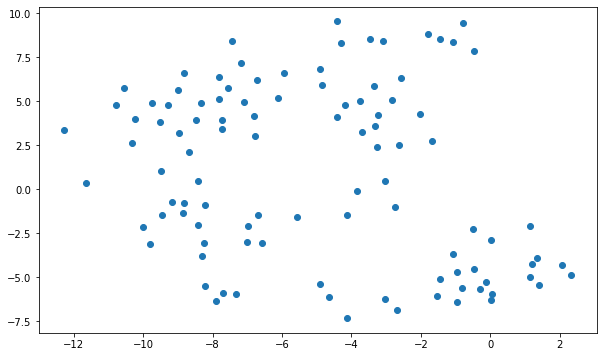

In [13]:
tsne = manifold.TSNE(n_components = 2, init = 'pca',random_state = 0)
data_2d_tsne = tsne.fit_transform(scaled.values.T)

plt.figure(figsize = (10, 6))
plt.scatter(data_2d_tsne[:, 0], data_2d_tsne[:, 1])

Для кластеризации используем метод K-Means. Он требует явно задать число кластеров. После t-SNE преобразования можно на глаз выделить около 5 кластеров. Можно взять и больше, но обучение большего количества авторегрессий займет слишком много времени

In [14]:
CLUSTER_NUM=5
REGIONS_NUM=102

model = KMeans(n_clusters=CLUSTER_NUM,random_state = 0)
preds = model.fit_predict(scaled.values.T)

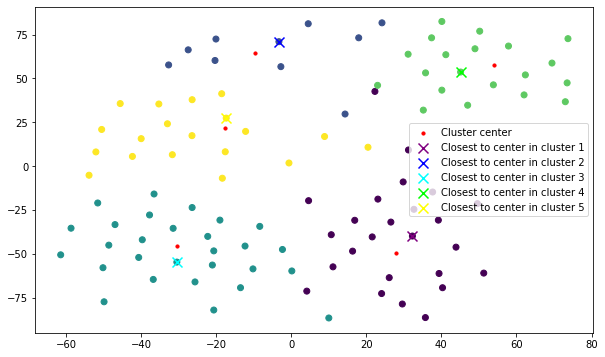

In [15]:
tsne = manifold.TSNE(n_components = 2, init = 'pca', random_state=0)
data_2d_tsne = tsne.fit_transform(np.vstack((scaled.values.T, model.cluster_centers_)))

#ищем индекс ближайшей к центру кластера поездки
cluster_centers_ind = []
for i in range(CLUSTER_NUM):
    dists = []
    for j in range(REGIONS_NUM):
        dists.append((data_2d_tsne[j,0]-data_2d_tsne[REGIONS_NUM+i,0])**2+
                     (data_2d_tsne[j,1]-data_2d_tsne[REGIONS_NUM+i,1])**2)
    cluster_centers_ind.append(dists.index(min(dists)))

plt.figure(figsize = (10, 6))
plt.scatter(data_2d_tsne[:REGIONS_NUM, 0], data_2d_tsne[:REGIONS_NUM, 1], c = preds)
plt.scatter(data_2d_tsne[REGIONS_NUM:, 0], data_2d_tsne[REGIONS_NUM:, 1], c = 'r',marker='o', s=10, label='Cluster center')
for i in range(CLUSTER_NUM):
    plt.scatter(data_2d_tsne[cluster_centers_ind[i], 0], data_2d_tsne[cluster_centers_ind[i], 1],
                c = ['purple','b','aqua','lime','yellow'][i], marker='x',
                s=100, label='Closest to center in cluster '+str(i+1))
plt.legend()

На scatter plot-e различными цветами показаны поездки, принадлежащие к различным кластерам, красные точки - центры кластеров, крестиками отмечены поездки, ближайшие к центру своего кластера. 

In [16]:
#для удобства разобъем данные на список отдельных таблиц по кластерам
clusters = [data[data.columns[list(filter(lambda x: preds[x] == c_num,range(len(preds))))]] for c_num in range(CLUSTER_NUM)]

In [17]:
#отсортируем по размеру кластера
clusters = sorted(clusters, key = lambda x: x.shape[1])
CLUSTER_SIZES = [clusters[i].shape[1] for i in range(CLUSTER_NUM)]
CLUSTER_SIZES

[10, 19, 20, 25, 28]

In [18]:
preds

array([0, 2, 2, 0, 0, 0, 0, 3, 3, 0, 2, 4, 4, 4, 4, 3, 3, 3, 0, 0, 2, 4,
       2, 2, 3, 3, 3, 4, 4, 3, 3, 0, 0, 0, 0, 0, 2, 2, 3, 3, 3, 1, 2, 2,
       0, 0, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 0, 4, 3, 3, 3, 3,
       0, 2, 2, 2, 2, 4, 4, 4, 4, 3, 1, 2, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0])

In [19]:
pd.DataFrame(preds).to_csv('clusters.csv',index=False)

In [20]:
#сохраним кластеры на диск
for clstr in range(CLUSTER_NUM):
    clusters[clstr].to_csv('data_march-june_cluster{}.csv'.format(clstr), index=False)

In [21]:
#и выделим центры кластеров в отдельную таблицу
cluster_centers = data.iloc[:,cluster_centers_ind]
cluster_centers

,1233,1482,1333,1177,1441
0,234.0,12.0,75.0,159.0,6.0
1,110.0,8.0,44.0,97.0,2.0
2,55.0,5.0,36.0,45.0,2.0
3,53.0,2.0,17.0,60.0,0.0
4,64.0,5.0,34.0,34.0,4.0
...,...,...,...,...,...
2923,730.0,7.0,650.0,261.0,2.0
2924,707.0,9.0,526.0,323.0,3.0
2925,854.0,12.0,511.0,438.0,3.0
2926,945.0,17.0,410.0,570.0,5.0


In [50]:
cluster_centers.to_csv('data_week4_cluster_centers.csv', index=False)

In [69]:
# то же для шкалированных данных, чтобы графики ниже были нагляднее
clusters_st = [scaled[scaled.columns[list(filter(lambda x: preds[x] == c_num,range(len(preds))))]] for c_num in range(CLUSTER_NUM)]

Чтобы убедиться, что кластеризация сработала адекватно, построим графики количества поездок в час для каждого из кластеров. Зеленым построен график центра кластера.

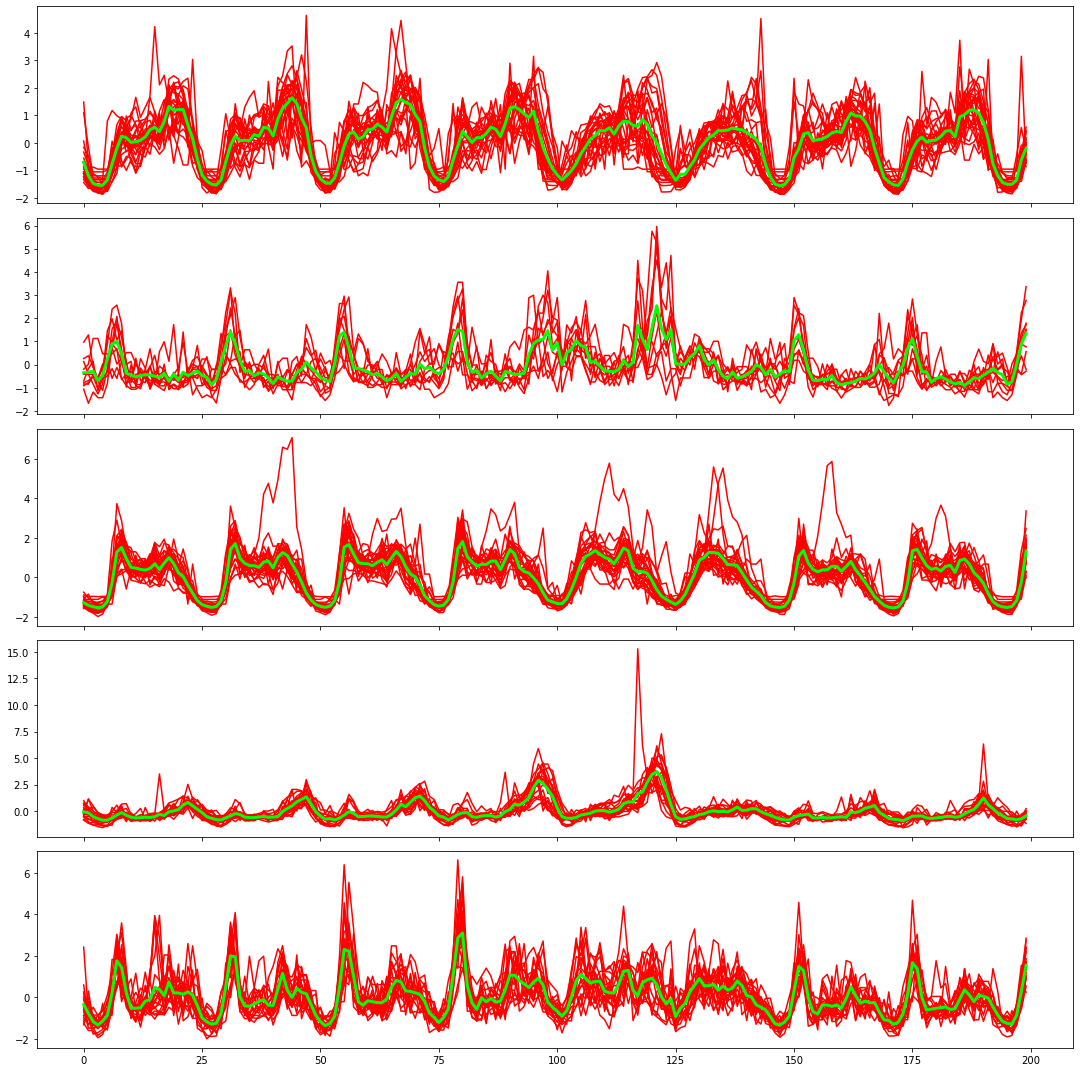

In [70]:
fig, axes = plt.subplots(ncols=1, nrows=CLUSTER_NUM, sharex=True, figsize=(15,15))

for i in range(CLUSTER_NUM):
    clusters_st[i][:200].plot(ax=axes[i], c='r', legend=False)
    axes[i].plot(model.cluster_centers_[i][:200], c='lime',label='mean',linewidth=3.0)
plt.tight_layout()
plt.show()

Как видим, в целом, каждый кластер действительно имеет характерную форму графика. Есть резко выделяющиеся поездки в некоторых кластерах, а пятый, похоже, попало все то, что не подошло ни в один другой. Качество анализа можно улучшить, например, увеличив количество кластеров (очевидно, что максимальное качество будет достигнуто при количестве кластеров равном количеству регионов), однако, это существенно увеличит сложность модели. Я оставлю 5 кластеров.

<h3>Анализ и обработка центральных для каждого кластера радов</h3>
Аналогично предыдущей неделе проанализируем наши 5 временных рядов (центры кластеров) и подберем параметры модели для каждого.

C:\Users\2\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  import sys


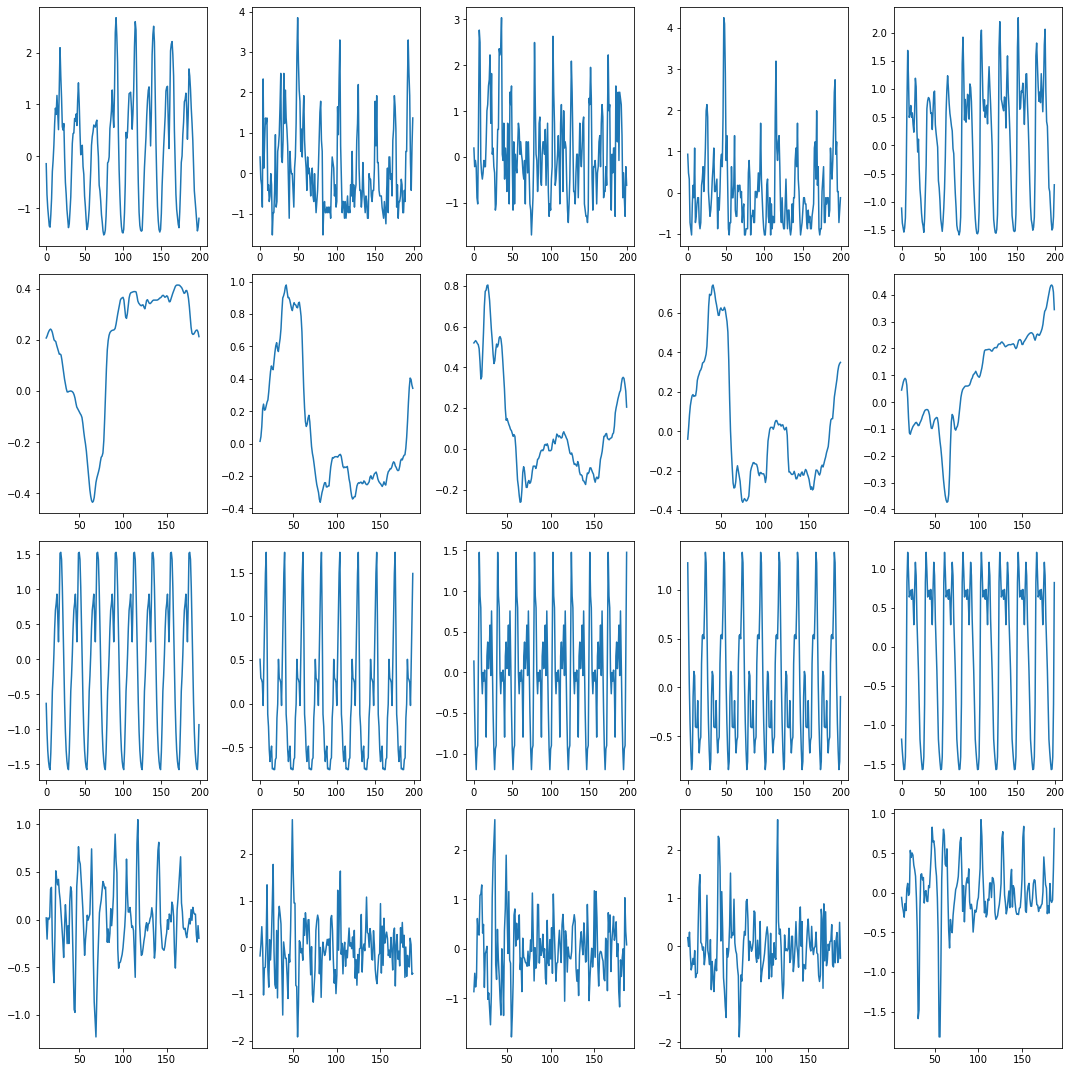

In [39]:
cluster_centers = pd.read_csv('data_week4_cluster_centers.csv')

#начнем с STL декомпозиции
fig, axes = plt.subplots(ncols=CLUSTER_NUM, nrows=4, figsize=(15,15))

for i in range(CLUSTER_NUM):    
    stl = sm.tsa.seasonal_decompose(cluster_centers.iloc[:200,i],freq=24)
    axes[0][i].plot(stl.observed)
    axes[1][i].plot(stl.trend)
    axes[2][i].plot(stl.seasonal)
    axes[3][i].plot(stl.resid)

plt.tight_layout()
plt.show()

Как минимум у первого и пятого ряда в остатках присутствует сезонность.

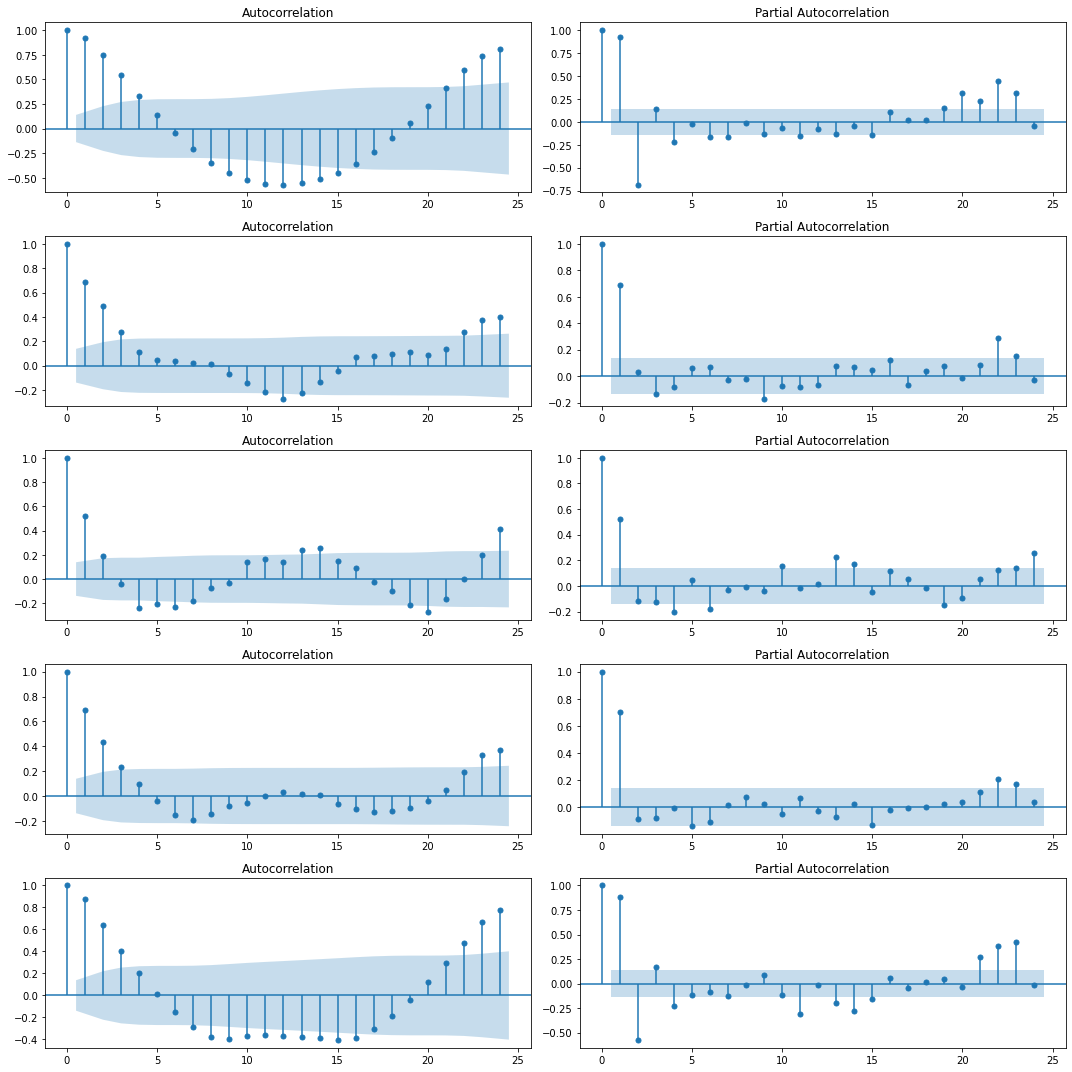

In [40]:
#автокорреляция
fig, axes = plt.subplots(ncols=2, nrows=5, figsize=(15,15))

for i in range(CLUSTER_NUM):    
    smt.graphics.plot_acf(cluster_centers.iloc[:200,i], ax=axes[i][0])
    smt.graphics.plot_pacf(cluster_centers.iloc[:200,i], ax=axes[i][1])

plt.tight_layout()
plt.show()

Как и в прошой неделе, произведем преобразование Бокса-Кокса и часовое и суточное дифференциирование, чтобы сделать ряд максимально стационарным

In [71]:
# обрабтное преобразование Бокса-Кокса
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [72]:
# прямое преобразование Бокса-Кокса
boxcox_centers = pd.DataFrame()
lmbda = np.zeros(CLUSTER_NUM)
for i in range(CLUSTER_NUM):
    boxcox_centers[i], _ = scs.boxcox(cluster_centers.iloc[:,i]+1) 

In [55]:
#сохраним данные на диск
boxcox_centers.to_csv('data_week4_boxcox_centers.csv', index=False)

In [17]:
boxcox_centers = pd.read_csv('data_week4_boxcox_centers.csv')
CLUSTER_NUM = 5
boxcox_centers.head()

,0,1,2,3,4
0,92.670552,3.486020,4.293758,2.759630,56.703989
1,67.016892,2.995795,3.836870,2.497166,33.886492
2,53.646696,2.850544,3.996730,2.394022,25.920950
3,43.681255,2.112969,3.836870,1.119146,17.017264
4,31.156714,4.623113,2.871859,0.701284,25.221858


In [76]:
# Однократное суточное дифференциирование
diff_day = pd.DataFrame()
for i in range(CLUSTER_NUM):
    diff_day[i] = boxcox_centers.iloc[:,i] - boxcox_centers.iloc[:,i].shift(24)
    
diff_hour = pd.DataFrame()    
# Можно также попробовать часовое и двукратное суточное
for i in range(CLUSTER_NUM):
    diff_hour[i] = diff_day[i] - diff_day[i].shift(1)
#for i in range(CLUSTER_NUM):
#    diff[i] = diff[i] -  diff[i].shift(1)

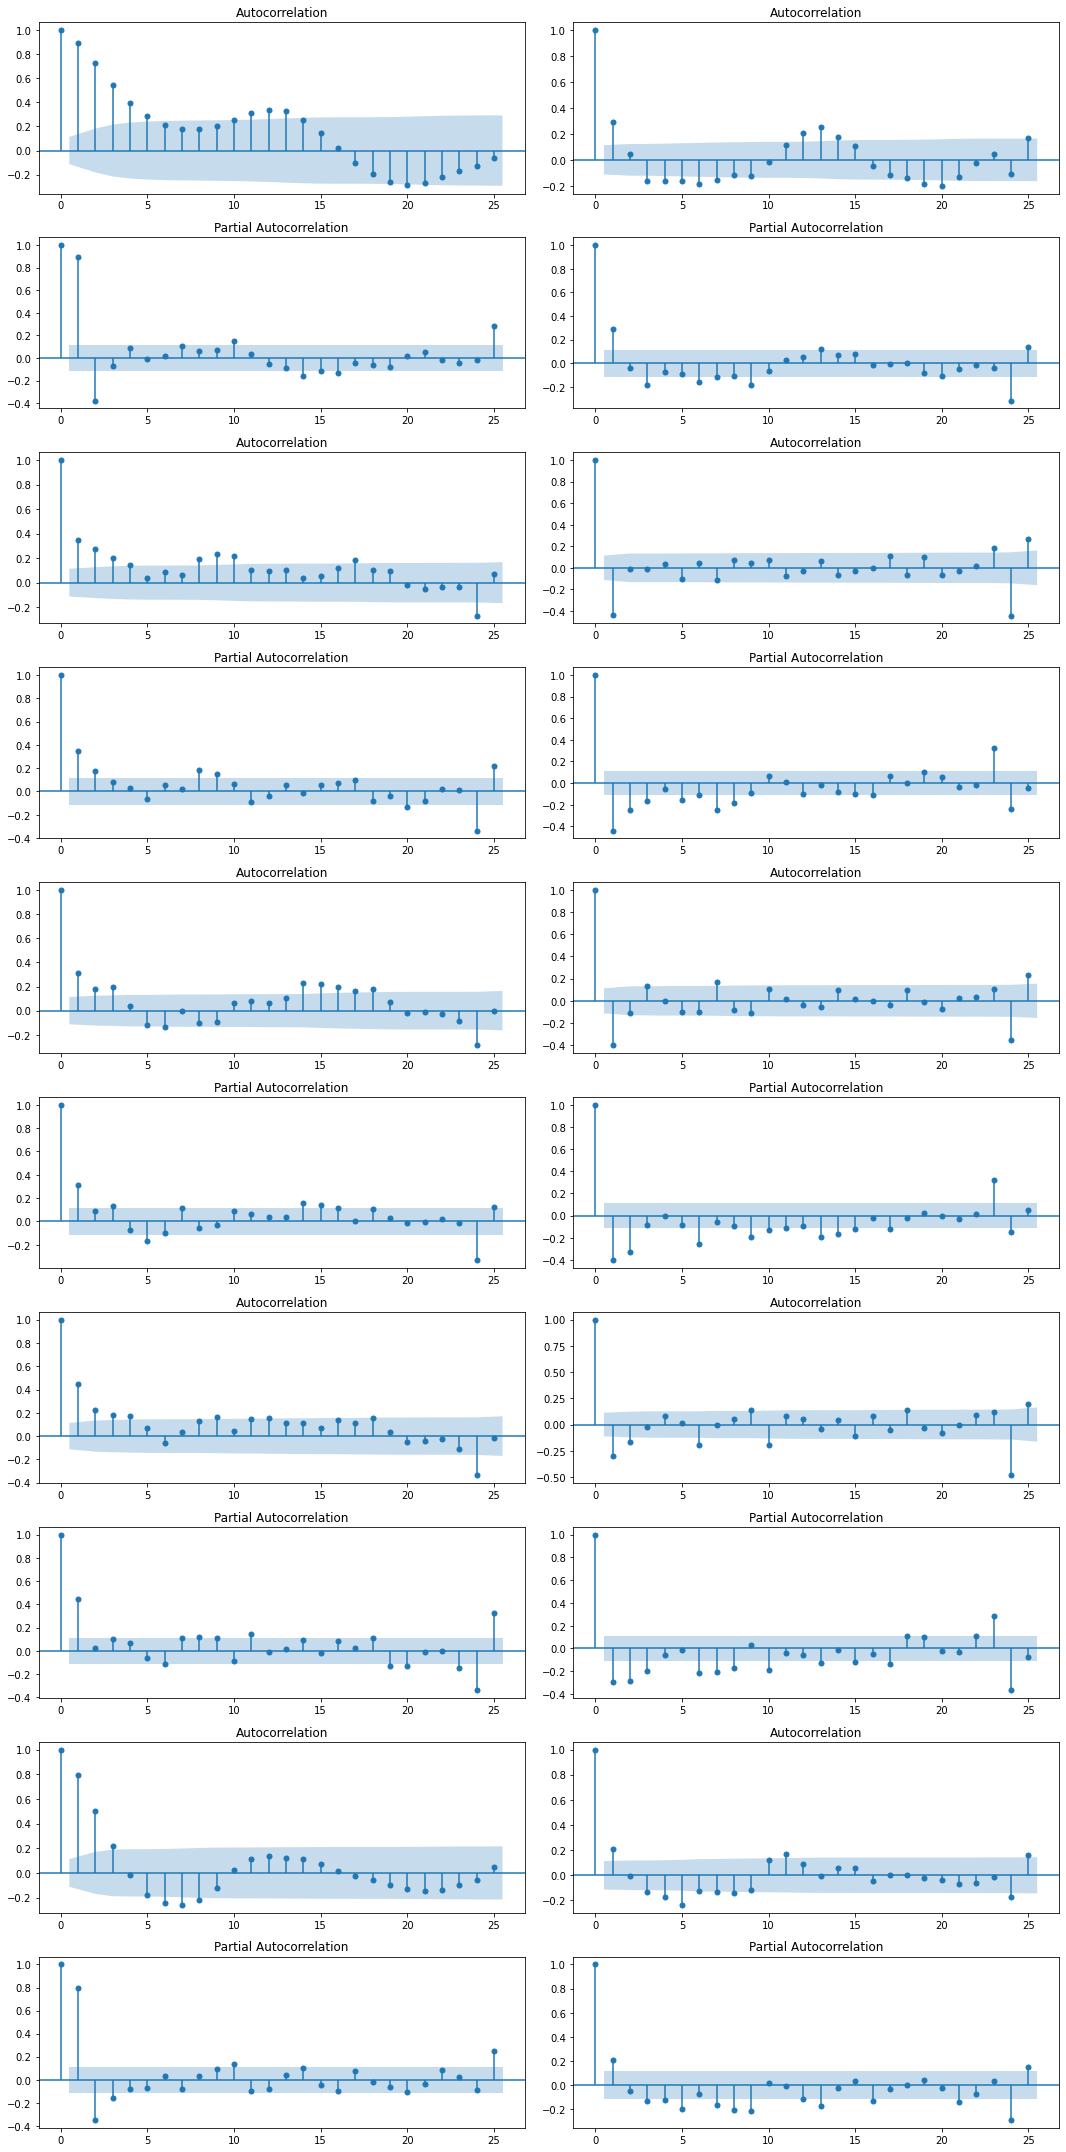

In [77]:
# Автокорреляция для стабилизированных и продифференциированных данных
fig, axes = plt.subplots(ncols=2, nrows=10, figsize=(15,30))

for i in range(CLUSTER_NUM):    
    smt.graphics.plot_acf(diff_day[50:350][i], lags=25, ax=axes[2*i][0])
    smt.graphics.plot_pacf(diff_day[50:350][i], lags=25, ax=axes[2*i+1][0])
    smt.graphics.plot_acf(diff_hour[50:350][i], lags=25, ax=axes[2*i][1])
    smt.graphics.plot_pacf(diff_hour[50:350][i], lags=25, ax=axes[2*i+1][1])

plt.tight_layout()
plt.show()


In [33]:
# Глядя на графики выше, прикинем параметры будующей модели SARIMAX для каждого кластера
p = [[0,1,2],
     [0,1,2],
     [0,1,2],
     [0,1,2],
     [0,1,2]]

d = [0,1,2]

q = [[0,1,2,3],
     [0,1,2,3],
     [0,1,2,3],
     [0,1,2],
     [0,1,2]]

Ps = [[0,1],
      [0,1],
      [0,1],
      [0,1],
      [0,1]]

Ds = [1,2]

Qs = [[0,1],
      [0,1],
      [0,1],
      [0,1],
      [0,1]]

In [92]:
#тест на стационарность для полученных рядов
def ADF_test(y):     
    test = sm.tsa.stattools.adfuller(y)
    print('adf: ', test[0]) 
    print('p-value: ', test[1])
    if test[0]> test[4]['5%']: 
        print('ряд не стационарен')
    else:
        print('ряд стационарен')

for i in range(CLUSTER_NUM): 
    print('ADF_test для кластера', i)
    ADF_test(diff[25:][i])

ADF_test для кластера 0
adf:  -9.956203448809521
p-value:  2.440488930760199e-17
ряд стационарен
ADF_test для кластера 1
adf:  -8.708187081987132
p-value:  3.651526432770394e-14
ряд стационарен
ADF_test для кластера 2
adf:  -7.512643571940742
p-value:  3.978090208774657e-11
ряд стационарен
ADF_test для кластера 3
adf:  -8.444172907313392
p-value:  1.730728971137875e-13
ряд стационарен
ADF_test для кластера 4
adf:  -7.7739127974161395
p-value:  8.772083074783132e-12
ряд стационарен


<h3>Построение внешних гармонических признаков</h3> 
Создадим внешние признаки на основе синусов и косинусов для учета сезонностей более высоких порядков, проведем отбор среди них при помощи линейной регрессии.

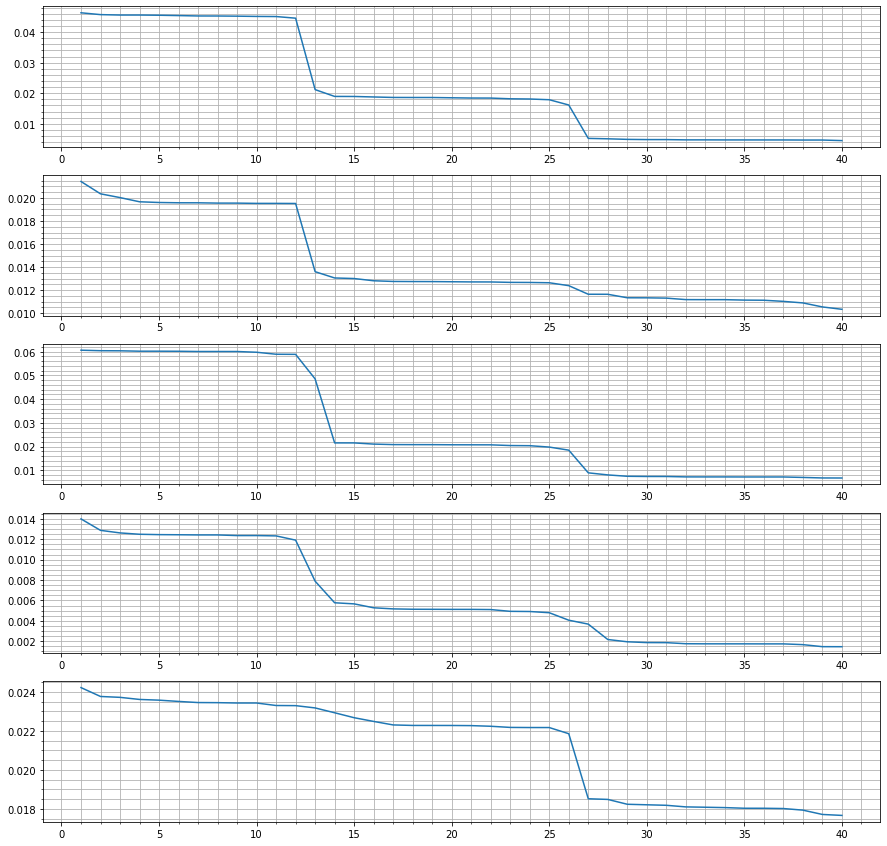

In [73]:
#создадим дополнительные признаки на основе синусов и косинусов, проведем регрессию этих признаков на целевые ряды
fig, axes = plt.subplots(ncols=1, nrows=CLUSTER_NUM, figsize=(15,15))


K_MAX = 40

# создадим таблицу экзогенных признаков
def build_exog(N, T, dt):
    X = np.vstack((np.sin(np.arange(T, T+dt)*2*np.pi/168),
                   np.cos(np.arange(T, T+dt)*2*np.pi/168)))
    for i in range(2, N//2+1):        
        X = np.vstack((X,np.sin(np.arange(T, T+dt)*2*np.pi*i/168)))
        X = np.vstack((X,np.cos(np.arange(T, T+dt)*2*np.pi*i/168)))
    X = X.T 
    return X

exog = build_exog(K_MAX, 0, date_to_hour(END)+1)

scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
scaled_centers = scaler.fit_transform(boxcox_centers)
scaled_exog = scaler.fit_transform(exog)

linear_estimators = []
for cluster in range(CLUSTER_NUM):
    mse_list = []
    linear_estimators.append(LinearRegression())
    for K in range(K_MAX):
        X = scaled_exog[:date_to_hour(END),:K+1]
        y = scaled_centers[:,cluster] 
        res = linear_estimators[-1].fit(X, y)
        mse_list.append(mean_squared_error(y, res.predict(X)))
    axes[cluster].plot(np.arange(1, K_MAX+1), mse_list)
    axes[cluster].minorticks_on()
    axes[cluster].grid(which='both')
    

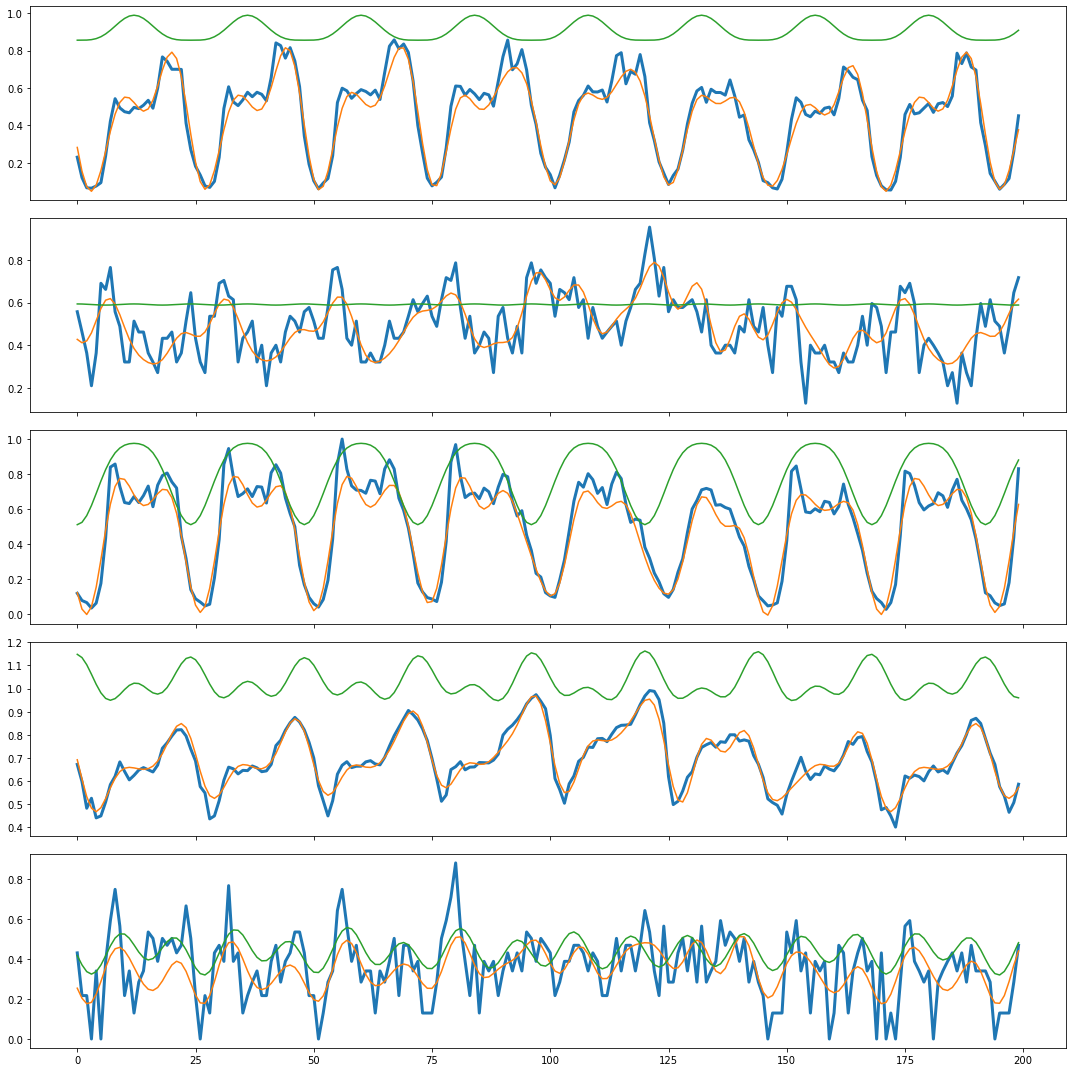

In [74]:
#Посмотрим, как результат линейной регресии на гармонические признаки соотносится с нашими данными
fig, axes = plt.subplots(ncols=1, nrows=CLUSTER_NUM, sharex=True, figsize=(15,15))

#гармонические признаки, которые можно отобрать, глядя на графики выше
exog_num = [[13,27],
            [27],
            [13,27],
            [13,14,27],
            [13,14,26]]

#функция, выполняющая предсказание регрессии только по НЕКОТОРЫМ признакам(параметр valueble - список интересующих признаков)
def restore_regression(x, coefs, intercept, valueble):
    return np.sum([coefs[i]*scaled_exog[x,i] for i in valueble])+intercept

for i in range(CLUSTER_NUM):
    # данные, нормированные на (0,1) (синяя кривая)
    axes[i].plot(scaled_centers[:200,i],linewidth=3)   
    # предсказание линейной регрессии (оранжевая кривая)
    axes[i].plot([restore_regression(x, linear_estimators[i].coef_,
                                     linear_estimators[i].intercept_ ,
                                     range(K_MAX))for x in range(200)])
    # предсказание линейной регрессии только по отобранным признакам (зеленая кривая)
    axes[i].plot([restore_regression(x, linear_estimators[i].coef_,
                                     linear_estimators[i].intercept_ ,
                                     exog_num[i])for x in range(200)])
plt.tight_layout()
plt.show()

Видим, что регрессия вполне неплохо описывает почти все кластеры. Вместо того, чтобы отбирать наиболее репрезентативные гармонические признаки(зеленые кривые), будем использовать в качестве внешнего признака полный результат регресии(оранжевые кривые). Это даст более точный результат и сократит ресурсозатратность обучения SARIMAX.

In [75]:
#Сохраняем результат регрессии в качестве внешнего признака для будующей модели SARIMAX
harmonic_estimation = pd.DataFrame([linear_estimators[i].predict(exog) for i in range(CLUSTER_NUM)]).transpose()
harmonic_estimation.to_csv('harmonic_estimation.csv',index=False)

<h3> Подбор гиперпараметров модели для каждого кластера </h3>

In [37]:
# Здесь я снова ввожу все необходимые переменные и считываю данные из файлов, чтобы не запускать все предыдущие ячейки
p = [[0,1,2],
     [0,1,2],
     [0,1,2],
     [0,1,2],
     [0,1,2]]

d = [0,1,2]

q = [[0,1,2,3],
     [0,1,2,3],
     [0,1,2,3],
     [0,1,2],
     [0,1,2]]

Ps = [[0,1],
      [0,1],
      [0,1],
      [0,1],
      [0,1]]

Ds = [1,2]

Qs = [[0,1],
      [0,1],
      [0,1],
      [0,1],
      [0,1]]

CLUSTER_NUM = 5
REGIONS_NUM = 102

boxcox_centers = pd.read_csv('data_week4_boxcox_centers.csv')
harmonic_estimation = pd.read_csv('harmonic_estimation.csv')

params = []
for cluster in range(CLUSTER_NUM):
    params.append(list(prdct(p[cluster],d,q[cluster],Ps[cluster],Ds,Qs[cluster])))

In [39]:
import warnings
#перебор гиперпараметров для всех 5 рядов по метрика AIC score
result_table = []
warnings.filterwarnings('ignore')

for cluster in range(0,2):
    best_aic = float("inf")
    results = []
    for param in tqdm(params[cluster]):
        try:
            model=sm.tsa.statespace.SARIMAX(boxcox_centers.iloc[:24*7*3,cluster], 
                                            exog = harmonic_estimation.iloc[:24*7*3,cluster], 
                                            order=(param[0], param[1], param[2]), 
                                            seasonal_order=(param[3], param[4], param[5], 24),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False,
                                           ).fit(disp=-1)
        except ValueError:
            continue
        
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])



    result_table.append(pd.DataFrame(results))
    result_table[-1].columns = ['p, d, q, Ps, Ds, Qs','AIC score']
    result_table[-1] = result_table[-1].sort_values(by = 'AIC score', ascending=True)
    print(result_table[-1].head())

  0%|                                                                                          | 0/192 [00:00<?, ?it/s]

    p, d, q, Ps, Ds, Qs    AIC score
153  (2, 0, 3, 0, 1, 1)  1476.031512
25   (0, 0, 3, 0, 1, 1)  1478.113642
89   (1, 0, 3, 0, 1, 1)  1479.155267
17   (0, 0, 2, 0, 1, 1)  1480.617836
9    (0, 0, 1, 0, 1, 1)  1481.514885


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [16:39<00:00,  5.21s/it]

    p, d, q, Ps, Ds, Qs    AIC score
157  (2, 0, 3, 1, 1, 1)  1443.782314
89   (1, 0, 3, 0, 1, 1)  1448.346820
57   (0, 1, 3, 0, 1, 1)  1449.178837
81   (1, 0, 2, 0, 1, 1)  1449.365877
49   (0, 1, 2, 0, 1, 1)  1449.867447


In [31]:
# здесь я вручную перепишу оптимальные параметры, чтобы не запускать каждый раз ячейку выше

#менее ресурсозатратный вариант   AIC score
optimal_light = [[2,0,3,0,1,1],  #1476
                 [2,0,3,1,1,1],  #1443
                 [0,0,1,0,1,1],  #775
                 [0,0,2,0,1,1],  #698
                 [2,1,2,1,1,1]]  #3473
"""
#менее ресурсозатратный вариант   AIC score
optimal_light = [[1,1,1,2,1,1],  #2779
                 [0,0,1,0,1,1],  #1447
                 [1,1,3,0,1,0],  #4663
                 [2,1,2,0,2,2],  #3722
                 [3,0,0,0,1,2]]  #464


#более точный, но ресурсозатратный вариант  
optimal_heavy = [[1,1,1,2,1,7],  #2761
                 [0,0,1,0,1,1],  #1447
                 [1,1,3,7,1,0],  #4451
                 [2,1,2,7,2,2],  #3660
                 [3,0,0,7,1,7]]  #435
"""

optimal = optimal_light

#Глобальные переменные
CLUSTER_NUM = 5
REGIONS_NUM = 102
START = datetime.datetime.strptime('2016-3','%Y-%m')
END = datetime.datetime.strptime('2016-7','%Y-%m')
TT_SPLIT = datetime.datetime.strptime('2016-5','%Y-%m')

def date_to_hour(date):
    return int((date-START).total_seconds()/3600)
    
TT_SPLIT_HOUR = date_to_hour(TT_SPLIT)     

In [32]:
TT_SPLIT_HOUR

1464

In [23]:
#Считываем данные и внешние признаки
data = []
for clstr in range(CLUSTER_NUM):    
    data.append(pd.read_csv('data_march-june_cluster{}.csv'.format(clstr)))
    
harmonic_estimation = pd.read_csv('harmonic_estimation.csv')


In [24]:
data[0]

,1278,1431,1480,1482,1483,1530,1532,1533,1580,1630
0,5.0,12.0,5.0,12.0,4.0,4.0,13.0,12.0,3.0,4.0
1,0.0,17.0,5.0,8.0,5.0,5.0,15.0,13.0,3.0,5.0
2,4.0,20.0,8.0,5.0,7.0,7.0,6.0,9.0,3.0,10.0
3,2.0,8.0,6.0,2.0,3.0,6.0,3.0,4.0,2.0,10.0
4,2.0,13.0,3.0,5.0,8.0,11.0,7.0,5.0,5.0,7.0
...,...,...,...,...,...,...,...,...,...,...
2923,18.0,14.0,5.0,7.0,8.0,2.0,3.0,7.0,3.0,2.0
2924,11.0,19.0,12.0,9.0,9.0,6.0,5.0,8.0,0.0,1.0
2925,13.0,15.0,6.0,12.0,7.0,5.0,1.0,8.0,1.0,2.0
2926,7.0,23.0,13.0,17.0,19.0,12.0,6.0,26.0,4.0,3.0


In [25]:
#Преобразование Бокса-Кокса для всех регионов
boxcox = [np.zeros((data[cluster].shape[0],data[cluster].shape[1])) for cluster in range(CLUSTER_NUM)]
lmbd = [np.zeros((data[cluster].shape[1])) for cluster in range(CLUSTER_NUM)] #Параметры преобразования

for cluster in range(CLUSTER_NUM):
    for column in range(data[cluster].shape[1]):
        boxcox[cluster][:,column], lmbd[cluster][column] = scs.boxcox(data[cluster].iloc[:,column]+1) 
        
# обрабтное преобразование Бокса-Кокса
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y)-1)
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda)-1)


In [36]:
import os.path
import warnings
warnings.filterwarnings('ignore')

#Длина выборки для обучения в часах(отсчитывается от 01 мая 00:00 в обратную сторону)
TRAIN_LEN = 24*7*8 

#Обучаем модели для всех регионов
for cluster in range(CLUSTER_NUM): #Цикл по всем кластерам
    exog = harmonic_estimation.iloc[0:TT_SPLIT_HOUR,cluster]   #Внешние признаки
    for column in range(boxcox[cluster].shape[1]): #Цикл по всем регионам внутри кластера
        endog = boxcox[cluster][0:TT_SPLIT_HOUR,column].copy() #Данные

        model = sm.tsa.statespace.SARIMAX(endog, 
                                          exog = exog, 
                                          order=(optimal[cluster][0], optimal[cluster][1], optimal[cluster][2]), 
                                          seasonal_order=(optimal[cluster][3], optimal[cluster][4], optimal[cluster][5],24))
        res = model.fit()
        res.save("models/region_{}.pickle".format(data[cluster].columns[column]))    #Сохраняем обученную модель в файл

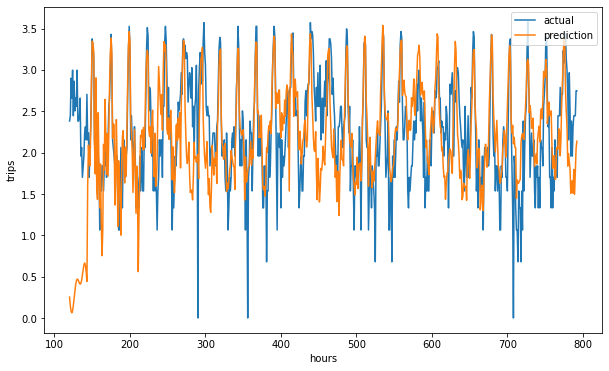

In [111]:
#Проверим адекватность модели
cluster, region = 0,5 #возьмем произвольный кластер и регион
loaded_res = sarimax.SARIMAXResultsWrapper.load("models/res_{}_{}.pickle".format(cluster,region))#загрузим модель из файла

#будем строить график начиная с недели до 1 мая, и заканчивая неделей после
plot_start = TT_SPLIT_HOUR - 24*7*8
plot_end = TT_SPLIT_HOUR - 24*7*4

#Начало и конец предсказания относительно точки, с которой модель начинала обучаться
predict_start = plot_start - (TT_SPLIT_HOUR - TRAIN_LEN) # = 2 недели
predict_end =  plot_end - (TT_SPLIT_HOUR - TRAIN_LEN)    # = 4 недели

actual = boxcox[cluster][plot_start : plot_end+1,region] #реальные данные

#строим предсказание
prediction = loaded_res.predict(start=predict_start, end = predict_end,
                           exog = harmonic_estimation.iloc[TT_SPLIT_HOUR:plot_end+1,0]
                          )

#строим график
plt.figure(figsize = (10, 6))
plt.plot(np.arange(plot_start,plot_end+1),actual)
plt.plot(np.arange(plot_start,plot_end+1),prediction);
plt.xlabel('hours')
plt.ylabel('trips')
plt.legend(('actual', 'prediction'),loc='upper right')

<h3>Вычисление ошибки прогноза</h3>
По функционалу:
$$Q_{may}=\frac{1}{R\cdot739\cdot61}\sum_{r=1}^{R}\sum_{T=t_{start}}^{t_{end}}\sum_{i=1}^{6}|y_{true}-y|$$

In [2]:
#Парсер ячеек со временем
def filter_datetime(x):
    try:
        return datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S')
    except:
        return np.nan

# Год и месяц начала и конца считывания данных (март-июнь)
START = datetime.datetime.strptime('2016-3','%Y-%m')
END = datetime.datetime.strptime('2016-7','%Y-%m')

# 1 мая разделяет обучающую и тестовую выборки
TT_SPLIT = datetime.datetime.strptime('2016-5','%Y-%m')

# Функция для преобразования даты в кол-во часов от начала считывания
def date_to_hour(date):
    return int((date-START).total_seconds()/3600)
#Глобальные переменные
CLUSTER_NUM = 5  
REGIONS_NUM = 102

#Длина выборки для обучения в часах от 01 мая 00:00 в обратную сторону
TRAIN_LEN = 24*7*4 #Три недели

def date_to_hour(date):
    return int((date-START).total_seconds()/3600)
    
TT_SPLIT_HOUR = date_to_hour(TT_SPLIT)


In [3]:
#Считываем данные и внешние признаки
data = []
for clstr in range(CLUSTER_NUM):    
    data.append(pd.read_csv('data_march-june_cluster{}.csv'.format(clstr)))
    
harmonic_estimation = pd.read_csv('harmonic_estimation.csv')

In [4]:
#Преобразование Бокса-Кокса для всех регионов
boxcox = [np.zeros((data[cluster].shape[0],data[cluster].shape[1])) for cluster in range(CLUSTER_NUM)]
lmbd = [np.zeros((data[cluster].shape[1])) for cluster in range(CLUSTER_NUM)]

for cluster in range(CLUSTER_NUM):
    for column in range(data[cluster].shape[1]):
        boxcox[cluster][:,column], lmbd[cluster][column] = scs.boxcox(data[cluster].iloc[:,column]+1) 

# обрабтное преобразование Бокса-Кокса
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y)-1)
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda)-1)


In [11]:
lambdas = pd.DataFrame()
for cluster in range(CLUSTER_NUM):
    for column in range(data[cluster].shape[1]):
        _, lmbd = scs.boxcox(data[cluster].iloc[:,column]+1)
        row = pd.Series([lmbd], name = data[cluster].columns[column])
        lambdas = lambdas.append(row)

In [13]:
lambdas.to_csv('lambdas.csv')

In [5]:
#функция, обрабатывающая предсказание
def interpret(x):
    if x is np.nan or x<0: #заменяет отрицательные числа на 0, т.к. не может быть отрицательного числа поездок
        x = 0
    try:
        round(x)           #и округляет до ближайшего целого
    except ValueError:
        x=0
    return x

#вспомогательная функция для вычисления ошибки для конкретного региона
def error(cluster, region, T_start, T_end, dt):
    try:
        # Загружаем модель
        model = sarimax.SARIMAXResultsWrapper.load("models/res_{}_{}.pickle".format(cluster,region))
    except KeyError:
        print(cluster, region)
        
    #Час, начиная с которого обучалась модель
    model_start = TT_SPLIT_HOUR - TRAIN_LEN 
    
    #Крайние даты начала истории
    T_start = date_to_hour(datetime.datetime.strptime(T_start,'%Y.%m.%d %H:%M'))
    T_end = date_to_hour(datetime.datetime.strptime(T_end,'%Y.%m.%d %H:%M'))
    
    #Внешние признаки
    exog = harmonic_estimation.iloc[:,cluster]
    
    #Инициализируем сумму
    outer_sum = 0
    
    #Цикл, задающий начало истории
    for T in range(T_start+1,T_end+2):
        #Строим и обрабатываем предсказание
        prediction = model.predict(start=T-model_start, end=T+dt-model_start, exog=exog[TT_SPLIT_HOUR:T+dt+1])
        prediction = np.array([invboxcox(i, lmbd[cluster][region]) for i in prediction])
        prediction = np.array([interpret(i) for i in prediction])

        #Инициализируем внутреннюю сумму
        inner_sum = 0
        #Цикл, суммирующий ошибку для 6-ти предсказаний
        for i in range(dt): 
            inner_sum += abs(data[cluster].iloc[T+i, region]-prediction[i])
        outer_sum += inner_sum
    return outer_sum

In [34]:
#Инициализируем ошибку
err = 0

#Считаем ошибку для каждого кластера
for cluster in range(CLUSTER_NUM):
    for region in range(data[cluster].shape[1]):
        err += error(cluster, region, '2016.04.30 23:00', '2016.05.31 17:00', 6)
        
err /= 6*739*REGIONS_NUM
print(err)


33.69155312828645


Значение функционала ошибки 33.68


<h3>Построение таблицы предсказаний</h3>


In [6]:
#построение строки id как требуется в задании
def get_id(region, hour, i):
    date = START + datetime.timedelta(seconds=hour*3600)
    return '{0}_{1}_{2}_{3}'.format(region,date.date(),date.hour, i)
                              
                                
#построение таблицы с предсказаниями
ResultTable = pd.DataFrame(columns=['id','y'])

#Крайние значания начала истории
T_start = date_to_hour(START)
T_end = date_to_hour(END)
CLUSTER_NUM = 5

#Длина прогноза
dt = 6

#Точка во времени, с которой модель начинала обучение
model_start = T_start


In [7]:
TT_SPLIT_HOUR, T_start, T_end

(1464, 0, 2928)

In [8]:
ResultTable = pd.DataFrame(columns=['id','y'])


for cluster in range(CLUSTER_NUM):  #Цикл по всем кластерам
    exog = harmonic_estimation.iloc[:,cluster]  #Внешние признаки
    for region in tqdm(range(boxcox[cluster].shape[1])): #Цикл по всем регионам в кластере
        model = sarimax.SARIMAXResultsWrapper.load("models/region_{}.pickle".format(data[cluster].columns[region])) #Загрузка модели
        for T in range(T_start,T_end+1): #Цикл по всем началам истории
            
            #Строим и обрабатываем предсказание
            
            if T< TT_SPLIT_HOUR:
                exog_range = [T]
            else:
                exog_range = range(TT_SPLIT_HOUR,T+1)

            prediction = model.predict(start=T, end=T, exog=exog[exog_range])[T]
            prediction = invboxcox(prediction, lmbd[cluster][region])
            prediction = interpret(prediction)
            
            #Записываем предсказания в таблицу
            new_row = {'id':'{0}_{1}'.format(data[cluster].columns[region], T), 'y': prediction}
            ResultTable = ResultTable.append(new_row, ignore_index=True)

 21%|█████████████████▎                                                                | 4/19 [07:17<26:37, 106.49s/it]C:\Users\2\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log
  
100%|███████████████████████████████████████████████████████████████████████████████| 28/28 [1:02:55<00:00, 134.84s/it]


In [9]:
ResultTable.iloc[-20:]

,id,y
298738,1733_2909,0.0
298739,1733_2910,0.0
298740,1733_2911,0.0
298741,1733_2912,0.0
298742,1733_2913,0.0
298743,1733_2914,0.0
298744,1733_2915,0.0
298745,1733_2916,0.0
298746,1733_2917,0.0
298747,1733_2918,0.0


In [10]:
ResultTable.to_csv('Result_1.csv', index=False)

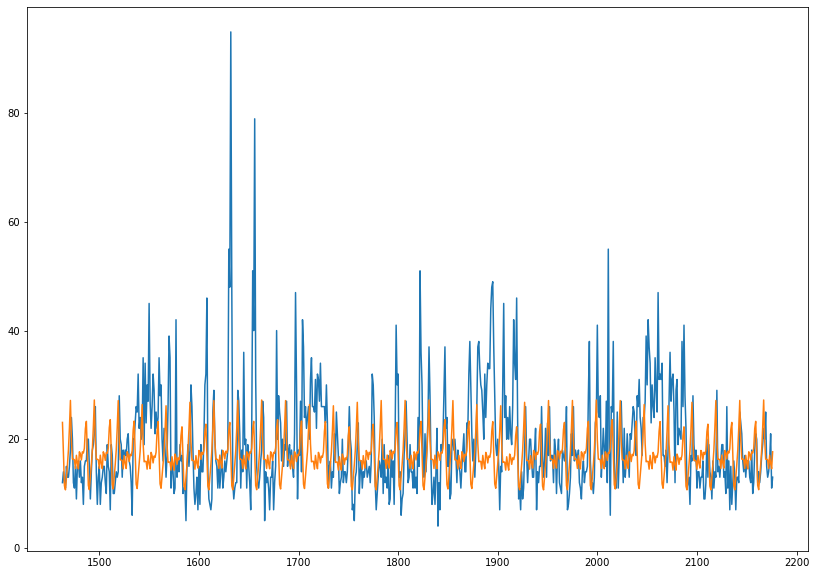

In [12]:
# Проверим адекватность таблицы
# Для этого сравним визуально прогноз(каждую 6-ую запись в таблице для некоторого региона)
# с реальными данными за июнь
ResultTable = pd.read_csv('Result.csv')
#Глобальные переменные
CLUSTER_NUM = 5
REGIONS_NUM = 102
START = datetime.datetime.strptime('2016-4','%Y-%m')
END = datetime.datetime.strptime('2016-7','%Y-%m')
TT_SPLIT = datetime.datetime.strptime('2016-5','%Y-%m')
T_start = '2016.05.31 23:00' 
T_end = '2016.06.30 17:00'
T_start = date_to_hour(datetime.datetime.strptime(T_start,'%Y.%m.%d %H:%M'))
T_end = date_to_hour(datetime.datetime.strptime(T_end,'%Y.%m.%d %H:%M'))

def date_to_hour(date):
    return int((date-START).total_seconds()/3600)
    
TT_SPLIT_HOUR = date_to_hour(TT_SPLIT)     

#Считываем данные и внешние признаки
data = []
for clstr in range(CLUSTER_NUM):    
    data.append(pd.read_csv('data_week4_cluster{}.csv'.format(clstr)))
    

plt.figure(figsize = (14, 10))
plt.plot(np.arange(T_start,T_end),data[0].iloc[T_start:T_end,0]);
plt.plot(np.arange(T_start,T_end),ResultTable.iloc[0:(T_end-T_start)*6:6,1]);

Вывод:
Видно, что модель хорошо описывает периодичность (форму, характер колебаний), но плохо справляется с непериодическими (случайными) шумами, что ожидаемо для авторегрессионной модели. Качество предсказания за июнь и май, вероятно, можно было улучшить, взяв в качестве обучающей выборки июнь и май прошлых лет, а не апрель.

Ссылка на сабмишн: https://www.kaggle.com/submissions/21592823/21592823.raw